In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ust_wildfire.temperature import average_yearly_temp, average_monthly_temp
from ust_wildfire.wildfire_stat import filter_lifetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [3]:
# Load the data
df_fire = pd.read_csv(f"../data/alberta.csv")
df_ystat = pd.read_csv(f"../data/results/alberta_yearly_stat.csv")
df_mstat = pd.read_csv(f"../data/results/alberta_monthly_stat.csv")
df_temp = pd.read_csv(f"../data/alberta_monthly_temp.csv")

# Get the data in the time range of interest
years = np.arange(1961, 2019)
temp = average_yearly_temp(df_temp, years)
temp_m = average_monthly_temp(df_temp)
df_ystat = df_ystat[(df_ystat["year"].isin(years))]


# Exclude events with undefined end-time and outliers that has >1 lifetime
df_fire = df_fire.dropna(subset=["end_time"])
df_fire = filter_lifetime(df_fire, 365)

When comparing the various statistics of wildfire events (e.g. count, average size, etc.) and the average temperature over the years, we can often find a very similar increasing trend. The increasing temperature trend is clearly the sign of global warming change. This naturally make us wonder, is the upward trends in wildfire another consequence of global climate change?

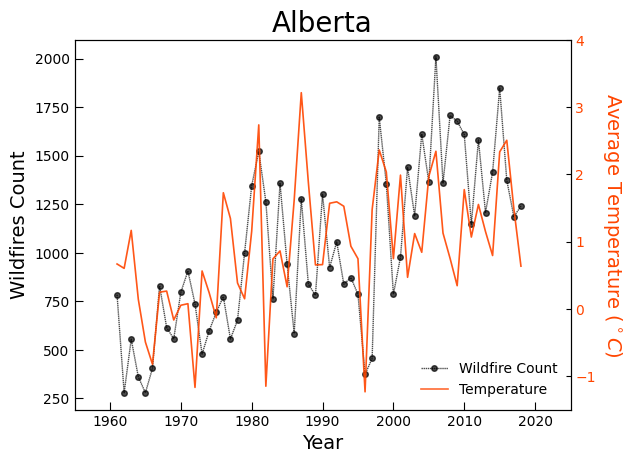

In [21]:
fig, ax = plt.subplots()

ax.plot(df_ystat["year"], df_ystat["count"], color="black", marker="o",
        label="Wildfire Count", ms=4, lw=1, alpha=0.7, linestyle=(0, (1, 0.5)))

ax.set_title("Alberta", fontsize=20)

ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Wildfires Count", fontsize=14)
ax.set_xlim(1955, 2025)

ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(which="major", length=6)
ax.tick_params(which="minor", length=4)

# Make the legend
ax.plot([], [], color="orangered", alpha=0.8, lw=1.2, label="Temperature")
ax.legend(loc="lower right", frameon=False, fontsize=10)


# Add the temperature curve
axt = ax.twinx()
axt.plot(years, temp, color="orangered", alpha=0.9, lw=1.2)
axt.set_ylabel(r"Average Temperature ($^\circ C$)", color="orangered",
                fontsize=14, rotation=270, labelpad=20)
axt.tick_params(axis="y", labelcolor="orangered", labelsize=10,
                direction="in")
axt.set_ylim(-1.5, 4)

plt.show()

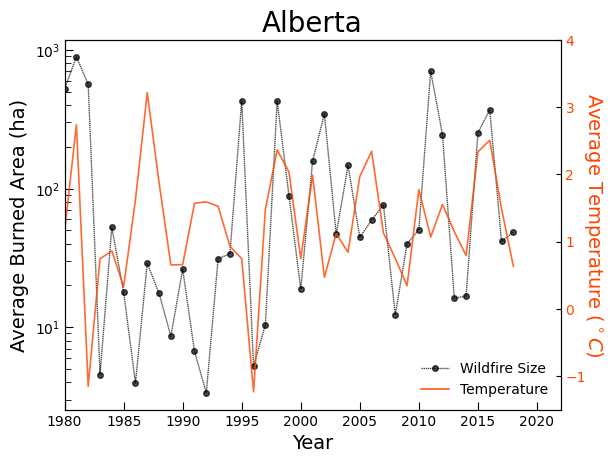

In [20]:
fig, ax = plt.subplots()

ax.plot(df_ystat["year"], df_ystat["avg_size"], color="black", marker="o",
            label="Wildfire Size", ms=4, lw=1, alpha=0.7, linestyle=(0, (1, 0.5)))


ax.set_title("Alberta", fontsize=20)

ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Average Burned Area (ha)", fontsize=14)
ax.set_xlim(1980, 2022)
ax.set_yscale("log")

ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(which="major", length=6)
ax.tick_params(which="minor", length=4)

# Make the legend
ax.plot([], [], color="orangered", alpha=0.9, lw=1.2, label="Temperature")
ax.legend(loc="lower right", frameon=False, fontsize=10)


# Add the temperature curve
axt = ax.twinx()
axt.plot(years, temp, color="orangered", alpha=0.8, lw=1.2)
axt.set_ylabel(r"Average Temperature ($^\circ C$)", color="orangered",
                fontsize=14, rotation=270, labelpad=14)
axt.tick_params(axis="y", labelcolor="orangered", labelsize=10,
                direction="in")
axt.set_ylim(-1.5, 4)

plt.show()

As a sanity check, we can also compare the monthly wildfire statistics with the monthly average temperature. Not so surprisingly, the summer months tend to have the most wildfires.

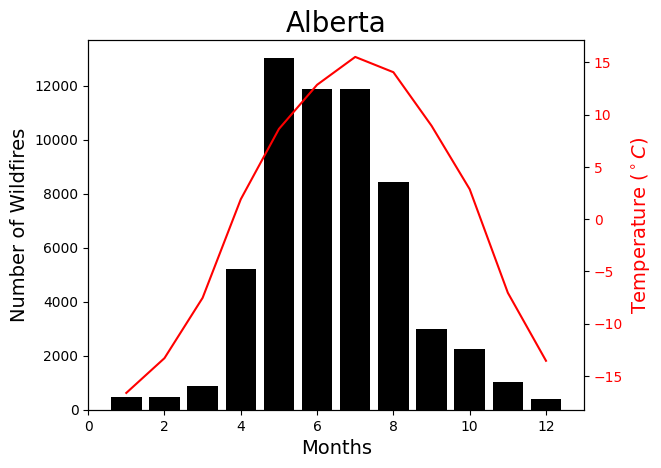

In [18]:
fig, ax = plt.subplots()
ax.bar(df_mstat["month"], df_mstat["count"], color="black")

ax.set_title("Alberta", fontsize=20)
ax.set_xlabel("Months", fontsize=14)
ax.set_ylabel("Number of Wildfires", fontsize=14)
ax.set_xlim(0, 13)

axt = ax.twinx()
axt.plot(np.arange(1, 13), temp_m, color="red")
axt.set_ylabel(r"Temperature ($^\circ C$)", color="red", fontsize=14)
axt.tick_params(axis="y", labelcolor="red")


plt.show()

Our goal is to establish a relation between wildfire statistics and the changing climate. To find such a relation, we first need to assign a temperature value to each wildfire event. Here I defined four possible temperature measures and plots their distribution: The start-time temperature $\bar{T}_0$, the first day average temperature $\bar{T}_1$, the first 10-day average temperature $\bar{T}_{10}$, and the lifetime average temperature $\bar{T}_\infty$. 

I found that the analysis results are actually not so sensitive to how we define this temperature. This is expectable, because as the fire become fully-developed, the surrounding temperature is not so important anymore. So I will focus on using the start-time temperature $\bar{T}_0$.

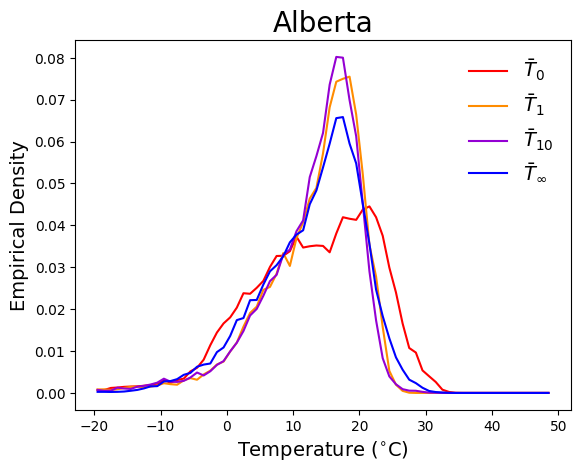

In [15]:
fig, ax = plt.subplots()

temp_var = {"temp_st": {"name": r"$\bar{T}_0$", "color": "red"},
            "temp_1d": {"name": r"$\bar{T}_{1}$", "color": "darkorange"},
            "temp_10d": {"name": r"$\bar{T}_{10}$", "color": "darkviolet"},
            "temp_lt": {"name": r"$\bar{T}_{\infty}$", "color": "blue"}
}

bins = np.arange(-20, 50, 1)
centers = (bins[1:] + bins[:-1]) / 2


for v in temp_var:
    hist, _ = np.histogram(df_fire[v].to_numpy(), bins=bins, density=True)
    ax.plot(centers, hist, label=temp_var[v]["name"], 
            color=temp_var[v]["color"])

ax.set_ylabel("Empirical Density", fontsize=14)
ax.set_xlabel("Temperature ($^{\circ}$C)", fontsize=14)
ax.legend(loc="upper right", frameon=False, fontsize=14)
ax.set_title("Alberta", fontsize=20)

plt.show()

Note that there are actually wildfires below $0^\circ$C in Alberta! Below I take a closer look into this sub-zero temperature range, and you can see the wildfire counts is not a small number in this range. For these fire, since they are below the freezing point of water, we are guessing their physical character would be somewhat different.

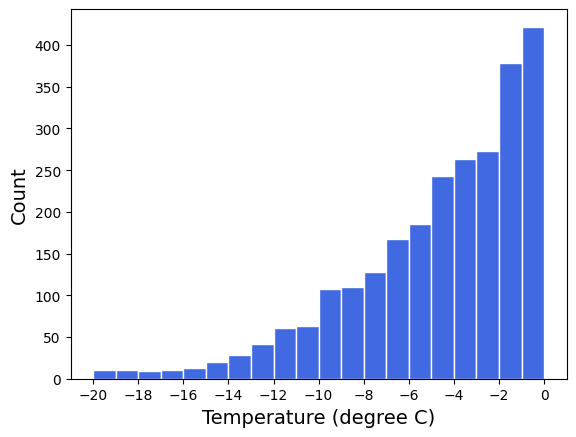

In [16]:
fig, ax = plt.subplots()

bins = np.arange(-20, 1, 1)
centers = (bins[1:] + bins[:-1]) / 2

ax.hist(df_fire[v].to_numpy(), bins=bins, density=False,
        color="royalblue", edgecolor="white")

ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("Temperature (degree C)", fontsize=14)
ax.set_xticks(np.arange(-20, 1, 2))

plt.show()